### this code: 

- opens all .nc files in the directory and merges them together 
- takes the difference within every day to make precipitation era5 land actually hourly 
- takes a slice of 1 day on the *new* and *original* data to see if its correct

In [24]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import glob


In [25]:
# read all data

directory = '/Users/varyabazilova/Desktop/uu/0_teaching/Msc_students/Leon/testera5land/ncfiles/'
files = glob.glob(directory + '*.nc')

# Use xarray.open_mfdataset to open and concatenate the .nc files
data = xr.open_mfdataset(files)
data = data.sortby('time')
data['tp'] = data.tp * 1000 # check units

# shift 1 time step back 
data = data.shift(time= -1, fill_value=0).sortby('time')

data = data.where(data >= 0, 0)



In [26]:
# define function 
def calculate_hourly_diff(arr):
    diff = arr - arr.shift(time=1, fill_value=0)
    return xr.DataArray(diff, coords=arr.coords)

# apply function
hourly_values = data.tp.groupby('time.dayofyear').apply(calculate_hourly_diff)
hourly_data = xr.Dataset({'hourly_values': hourly_values})


### check


In [27]:
''' calculate the sum within day in a shifted data, compare with the max within the same day in the original data '''
# slice coordinates
data = data.sel(latitude=29.0, longitude=84.0, method='nearest')
hourly_data = hourly_data.sel(latitude=29, longitude=84, method='nearest')


In [28]:
# slice data - take a day  
start_date = '2020-12-31T00:00:00.000000000'
end_date   = '2021-01-04T23:00:00.000000000'

# Slice the dataset for a day 
cut_sh = data.sel(time=slice(start_date, end_date))
cut_hourl = hourly_data.sel(time=slice(start_date, end_date))

print('new hourly data - daily sum:', round(cut_hourl.hourly_values.values.sum(), 6))
print('original data - daily max (cumulative sum):', round(cut_sh.tp.values.max(), 6))


new hourly data - daily sum: -5.293228
original data - daily max (cumulative sum): 4.369658


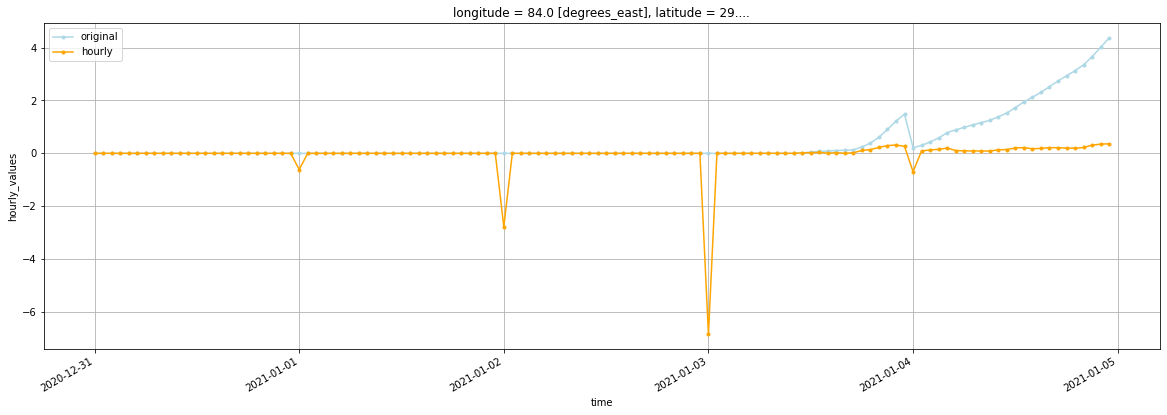

In [29]:
''' plot to see if its correct '''
plt.figure(figsize=(20, 6))
cut_sh['tp'].plot.line(x='time', marker='.', color ='lightblue', label ='original')
cut_hourl['hourly_values'].plot.line(x='time', marker='.', color ='orange', label = 'hourly')

plt.grid()
plt.legend()


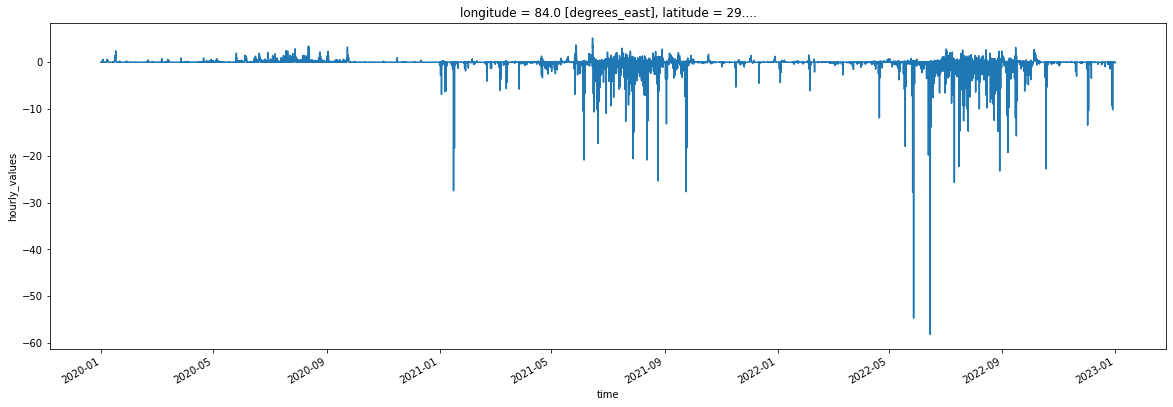

In [32]:
plt.figure(figsize=(20, 6))
hourly_data.hourly_values.plot()


In [31]:
cut_hourldf = cut_hourl.to_dataframe()


In [13]:
cut_hourldf


,longitude,latitude,hourly_values
time,,,
2020-12-30 00:00:00,84.0,29.0,0.010516
2020-12-30 01:00:00,84.0,29.0,-0.009015
2020-12-30 02:00:00,84.0,29.0,0.003006
2020-12-30 03:00:00,84.0,29.0,0.003006
2020-12-30 04:00:00,84.0,29.0,0.004508
...,...,...,...
2021-01-04 19:00:00,84.0,29.0,0.198793
2021-01-04 20:00:00,84.0,29.0,0.193164
2021-01-04 21:00:00,84.0,29.0,0.221297


In [14]:
datadiff = data.tp.diff(dim='time')
datadiff = datadiff.shift(time=1)
datadiff[0] = data.tp.isel(time=0)
df = datadiff.to_dataframe()


In [15]:
import xarray as xr

# Load your cumulative precipitation data into an xarray dataset
ds = data

# Calculate hourly precipitation
hourly_precip = xr.DataArray(
    ds.tp.values - ds.tp.shift(time=1).values,
    coords={'time': ds.time},
    dims={'time': ds.time.dims[0]}
)

# For the first hour of each day, set the value to the cumulative precipitation for that day
hourly_precip[0] = ds.tp[0]

# Now, you have an xarray variable `hourly_precip` with hourly precipitation values, correctly reset each day


In [ ]:
hourly_precip.plot()

## test 

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd

# Create sample data
temperature_data = np.tile(np.arange(0+5, 24+5), 3)  # Temperatures from 1 to 23 for 3 days
# precipitation_data = np.random.uniform(0, 5, size=(72, 1, 1))  # Generate random precipitation data for 3 days

# Define dimensions
time = pd.date_range(start="2023-01-01", periods=72, freq="H")  # Hourly time steps for 3 days
latitude = [0]
longitude = [0]

# Create xarray dataset
ds = xr.Dataset({
    'temperature': (['time', 'latitude', 'longitude'], temperature_data.reshape(72, 1, 1)),
    # 'precipitation': (['time', 'latitude', 'longitude'], precipitation_data)
},
    coords={'time': time, 'latitude': latitude, 'longitude': longitude}
)

# # Optional: Add attributes
# ds.attrs['description'] = 'Sample weather dataset'
# ds['temperature'].attrs['units'] = 'Celsius'
# ds['precipitation'].attrs['units'] = 'mm'

# Print the dataset
ds


In [ ]:
dsdf = ds.to_dataframe().reset_index().drop(['latitude', 'longitude'], axis = 1).set_index('time')
# dsdf

In [ ]:
dsdf['shifted'] = dsdf.temperature.shift(1, fill_value = 0)
dsdf['diff'] = dsdf.temperature - dsdf.shifted

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))
dsdf.plot(ax = ax)

In [ ]:
# dsdf['diff'].values

# # Extract the date portion of the datetime and group by it
# grouped = dsdf.groupby(dsdf['time'].dt.date)


In [ ]:
# # Define a custom function to calculate the difference
# def calculate_difference(group):
#     group['diff'] = group['temperature'] - group['temperature'].shift(1)
#     return group


# # Apply the custom function to each day group
# result_df = grouped.apply(calculate_difference)

In [ ]:
# df

In [ ]:
# define function 
def calculate_hourly_diff(arr):
    diff = arr - arr.shift(time=1, fill_value=0)
    return xr.DataArray(diff, coords=arr.coords)

# apply function
hourly_values = ds.temperature.groupby('time.dayofyear').apply(calculate_hourly_diff)
hourly_data = xr.Dataset({'hourly_values': hourly_values})


In [ ]:
fig, ax = plt.subplots(figsize = (20, 5))
hourly_data.hourly_values.plot(label = 'changed')
ds.temperature.plot(label = 'original')

plt.legend()

In [ ]:
# hourly_data.hourly_values

In [ ]:
# Function to calculate hourly differences with reset at midnight
def calculate_hourly_diff(arr):
    diff = np.diff(arr, prepend=0)
    return xr.DataArray(diff, coords=arr.coords)

# apply function
hourly_values = ds.temperature.groupby('time.dayofyear').apply(calculate_hourly_diff)
hourly_data = xr.Dataset({'hourly_values': hourly_values})


In [ ]:
fig, ax = plt.subplots(figsize = (20, 5))
hourly_data.hourly_values.plot(label = 'changed')
ds.temperature.plot(label = 'original')

plt.legend()

In [ ]:
data


In [ ]:
ds = data

In [ ]:
ds_cumul = ds.cumsum(dim = 'time')

In [ ]:
ds_cumul.tp.isel(time = 200).plot()

In [ ]:
ds_cumul_diff = ds_cumul.diff(dim = 'time')

In [ ]:
ds_cumul_diff.tp.isel(time = 200).plot()

In [ ]:
clip = ds_cumul_diff.sel(longitude = 84.0, latitude = 28.8, method = 'nearest')

In [ ]:
fig, ax = plt.subplots(figsize = (20, 5))
clip.tp.plot()